In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.constants import h,k,c
from scipy.optimize import curve_fit, brute, minimize
from astropy import units as u
from astropy.modeling.blackbody import blackbody_lambda, blackbody_nu
import time
#import emcee
#import sedfitter

import astropy
print(astropy.__version__)

import scipy
print(scipy.__version__)

import matplotlib
print(matplotlib.__version__)

print(np.__version__)

import winsound

%matplotlib notebook

print("Dependencies imported")

3.1
1.1.0
3.0.2
1.15.4
Dependencies imported


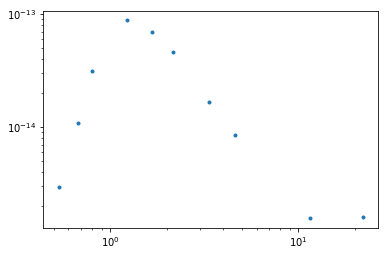

In [19]:
obsmags = [15.3202, 17.0689, 13.7354, 11.606, 11.060, 10.751, 10.550, 10.297, 9.294, 7.126]
obsmagerrs = [0.0121, 0.0254, 0.0028, 0.027, 0.023, 0.024, 0.023, 0.021, 0.031, 0.086]

G_ZP_Vega = 25.6883657251
GBp_ZP_Vega = 25.3513881707
GRp_ZP_Vega = 24.7619199882
        
G_ZP_AB = 25.7933969562
GBp_ZP_AB = 25.3805596387
GRp_ZP_AB = 25.1161276701
        
G_f0_AB = 10.**(0.4*G_ZP_AB)
GBp_f0_AB = 10.**(0.4*GBp_ZP_AB)
GRp_f0_AB = 10.**(0.4*GRp_ZP_AB)
        
G_Jy_per_photon = 3631./G_f0_AB
GBp_Jy_per_photon = 3631./GBp_f0_AB
GRp_Jy_per_photon = 3631./GRp_f0_AB
        
G_f0_Vega_photon = 10.**(0.4*G_ZP_Vega)
GBp_f0_Vega_photon = 10.**(0.4*GBp_ZP_Vega)
GRp_f0_Vega_photon = 10.**(0.4*GRp_ZP_Vega)
        
G_f0_vega = G_Jy_per_photon * G_f0_Vega_photon
GBp_f0_vega = GBp_Jy_per_photon * GBp_f0_Vega_photon
GRp_f0_vega = GRp_Jy_per_photon * GRp_f0_Vega_photon

zps = [G_f0_vega, GBp_f0_vega, GRp_f0_vega, 1594., 1024., 666.7, 309.54, 171.787, 31.674, 8.363]

obsfluxes_Jy = np.array([(zps[i]*10**(-0.4*obsmags[i])) for i in range(len(zps))])
obsfluxerrs_Jy = np.array([(np.sqrt((zps[i]*np.log(10)*obsfluxes_Jy[i]*-0.4)**2)) for i in range(len(zps))])

obsfluxes = np.array([(zps[i]*10**(-0.4*obsmags[i])) for i in range(len(zps))])*(1.0e-26)
obsfluxerrs = np.array([(np.sqrt((zps[i]*np.log(10)*obsfluxes[i]*-0.4)**2)) for i in range(len(zps))])*(1.0e-26)

wavelengths = np.array([0.673, 0.532, 0.797, 1.235, 1.662, 2.159, 3.35, 4.60, 11.56, 22.08])
wavelengths_meters = wavelengths*1.0e-6
frequencies = 299792458./wavelengths_meters

obs_nuFnu = frequencies * obsfluxes
obs_nuFnu_errs = frequencies*obsfluxerrs

plt.figure()
plt.errorbar(wavelengths, obs_nuFnu, fmt='.', yerr=obs_nuFnu_errs)
plt.xscale('log', nonposx = 'clip')
plt.yscale('log', nonposy = 'clip')
plt.show()

In [5]:
def fluxdrive_plot(spectname, binsize):
    spec_X, spec_S, spec_dict = import_spectrum(spectname, binsize)
    return spec_X, spec_S, spec_dict

def import_spectrum(spectname, binsize):
    spect_Xlist = []
    spect_Slist = []
    spect_dict = {}
    
    with open(spectname) as f:
        spectfilelist = f.readlines()
        
    testline = spectfilelist[0]
    test_res = [pos for pos, char in enumerate(testline) if char == '-']
    line_start = testline.index('1')
    
    flag1 = False
    flag2 = False
    
    flag1 = (test_res[0] < (7 + line_start))
    flag2 = (test_res[1] > (20 + line_start))
    
    #print flag1, flag2
    
    for line in spectfilelist:
        if (flag1 and flag2):
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag1:
            line_use = line[:13] + ' ' + line[13:25] + ' ' + line[25:]
        elif flag2:
            line_use = line[:25] + ' ' + line[25:]
        else:
            line_use = line
            
        datavec = line_use.split()
        xstr = datavec[0]
        sstr = datavec[1]
        sstr1 = sstr.replace('D','e')
        #print datavec
        #print sstr1
        
        x = float(xstr)
        s = float(sstr1)
        
        spect_Xlist.append(x)
        spect_Slist.append((10.**(s-8.)))
        spect_dict[x] = s
        
    spect_X_binned = []
    spect_S_binned = []
    
    #ents_per_bin = binsize*20.
    
    spect_X = np.array(spect_Xlist)
    spect_S = np.array(spect_Slist)
    
    return spect_X, spect_S, spect_dict

warm_disk_flux_nu 0.01316928630539724


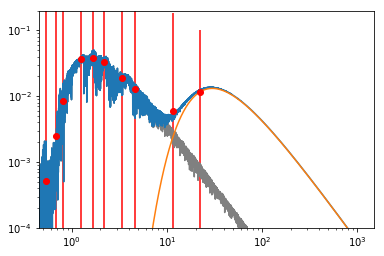

plotting_x_vec: [1494.78936241 1496.09032243 1497.39241471 1498.69564023 1500.        ]
full_model: [5.87809071e-20 5.86306685e-20 5.84808153e-20 5.83313463e-20
 5.81822607e-20]


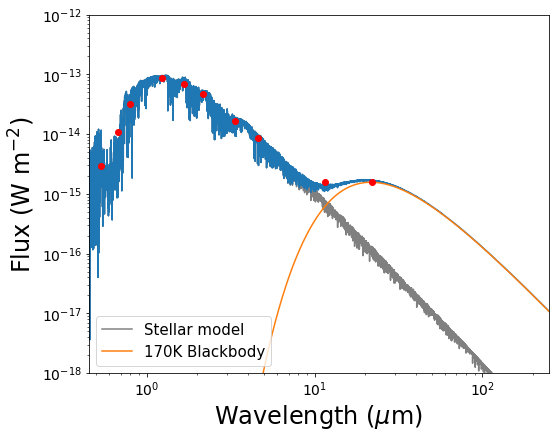

In [27]:
spect_file = '..\\..\\BTSettlstuff_use\\BT-Settl_M-0.0a+0.0\\lte029.0-4.0-0.0a+0.0.BT-Settl.spec.7'
        
spec_X, spec_S, spec_dict = fluxdrive_plot(spect_file,1)

plotting_logx_list = np.linspace(np.log10(0.25), np.log10(1500.), 10001).tolist()
plotting_x_vec = np.zeros(10001)

#plotting_logx_list.append(np.log10(200.))

plotting_logx_vec = np.array(sorted(plotting_logx_list))
    
for i in range(10001):
    plotting_x_vec[i] = 10.**(plotting_logx_vec[i])
    
plotting_xvec_angstroms = plotting_x_vec * 1.e4

rstar = 0.30 * 695700000.
distance = 3.08567758149137e16 * (1000./9.8599)

#flux_spec_S = spec_X * spec_S * ((rstar**2)/(distance**2)) * 0.0012

#plotting_flux_spec_S = np.interp(plotting_xvec_angstroms, spec_X, flux_spec_S)

rdstar = (rstar**2)/(distance**2) * 0.0012

plotting_xvec_meters = plotting_x_vec * 1.e-6
plotting_xvec_frequency = 299792458. / plotting_xvec_meters

#hot_disk_flux = blackbody_lambda(plotting_xvec_angstroms, 1071.) * np.pi * u.sr * 0.001 * u.s * u.cm * u.cm / u.erg * u.AA #1.0e10 * u.AA#* plotting_xvec_angstroms * 0.054 * 2.0e-22 * u.AA * u.cm * u.cm * u.s * np.pi * u.sr / u.erg #(0.054*(3050.**4)*rdstar/(1071.**4)) 
warm_disk_flux = blackbody_lambda(plotting_xvec_angstroms, 170.) * np.pi * u.sr * 0.001 * u.s * u.cm * u.cm / u.erg * u.AA #1.0e10 * u.AA#* plotting_xvec_angstroms * 0.070 * 1.5e-19 * u.AA * u.cm * u.cm * u.s * np.pi * u.sr / u.erg #(0.070*(3050.**4)*rdstar/(237.**4)) *0.001
#cold_disk_flux = blackbody_lambda(plotting_xvec_angstroms, 20.) * np.pi * u.sr * 0.001 * u.s * u.cm * u.cm / u.erg * u.AA

#print hot_disk_flux[-1]

#hot_disk_flux_nu = hot_disk_flux * plotting_xvec_meters / plotting_xvec_frequency * 1.0e26 * 2.0e-10
warm_disk_flux_nu = warm_disk_flux * plotting_xvec_meters / plotting_xvec_frequency * 1.0e26 * 4.5e-7
#cold_disk_flux_nu = cold_disk_flux * plotting_xvec_meters / plotting_xvec_frequency * 1.0e26 * 2.4e-5

print('warm_disk_flux_nu', max(warm_disk_flux_nu))

#ALMA_flux_uJy = 198.
#ALMA_flux_Jy = ALMA_flux_uJy * 1.0e-6
#ALMA_flux = ALMA_flux_Jy * (10**-26)
#ALMA_nuFnu = (232.0e9) * ALMA_flux

#ALMA_fluxerr_uJy = 15.
#ALMA_fluxerr_Jy = ALMA_fluxerr_uJy * 1.0e-6
#ALMA_fluxerr = ALMA_fluxerr_Jy * (10**-26)
#ALMA_nuFnuerr = (232.0e9) * ALMA_fluxerr


#plotting_xvec_frequency = 299792458./(plotting_x_vec * 1.e-6)

#hot_disk_flux = hot_disk_nuFnu * plotting_xvec_
#warm_disk_flux = warm_disk_nuFnu / plotting_xvec_frequency
spec_S_flux = spec_S * ((rstar**2)/(distance**2)) * 0.005 * spec_X * ((spec_X * 1.e-10) / 299792458.) * 1.0e26
plotting_spec_S_flux = np.interp(plotting_xvec_angstroms, spec_X, spec_S_flux) 

#print hot_disk_flux[-1]

full_model_flux = plotting_spec_S_flux + warm_disk_flux_nu# + hot_disk_flux_nu + cold_disk_flux_nu

#full_model_flux_200 = np.interp(200., plotting_x_vec, full_model_flux)
#print(full_model_flux_200)

#print(plotting_x_vec)

plt.figure()
#plt.errorbar(wavelengths, obs_nuFnu, color='r', fmt='o', yerr=obs_nuFnu_errs)
plt.errorbar(wavelengths, obsfluxes_Jy, color = 'r', fmt='o', yerr=obsfluxerrs_Jy)
#plt.errorbar(1300., ALMA_flux_Jy, color = 'k', fmt='o',yerr=ALMA_fluxerr_Jy)
plt.xscale('log', nonposx = 'clip')
plt.yscale('log', nonposy = 'clip')

plt.plot(plotting_x_vec, plotting_spec_S_flux,'gray')
plt.plot(plotting_x_vec, full_model_flux)
#plt.plot(plotting_x_vec, hot_disk_flux_nu)
plt.plot(plotting_x_vec, warm_disk_flux_nu)
#plt.plot(plotting_x_vec, cold_disk_flux_nu)

plt.xlim(0.45, 1500.)
#plt.ylim(10.**-17, 10.**-13)
plt.ylim(0.0001,0.2)
plt.show()

plotting_flux_spec_S = (plotting_spec_S_flux * 1.0e-26) * 299792458./plotting_xvec_meters
#hot_disk_nuFnu = (hot_disk_flux_nu * 1.0e-26) * 299792458./plotting_xvec_meters
warm_disk_nuFnu = (warm_disk_flux_nu * 1.0e-26) * 299792458./plotting_xvec_meters
#cold_disk_nuFnu = (cold_disk_flux_nu * 1.0e-26) * 299792458./plotting_xvec_meters

full_model = plotting_flux_spec_S + warm_disk_nuFnu #+ hot_disk_nuFnu + cold_disk_nuFnu

#print (200. in plotting_x_vec)
#print plotting_x_vec

#spec_S_flux_200 = np.interp(2000000., spec_X, spec_S_flux)
#hot_disk_flux_200 = blackbody_lambda(2000000., 1071.) * np.pi * u.sr * 0.001 * u.s * u.cm * u.cm / u.erg * u.AA #1.0e10 * u.AA#* plotting_xvec_angstroms * 0.054 * 2.0e-22 * u.AA * u.cm * u.cm * u.s * np.pi * u.sr / u.erg #(0.054*(3050.**4)*rdstar/(1071.**4)) 
#warm_disk_flux_200 = blackbody_lambda(2000000., 237.) * np.pi * u.sr * 0.001 * u.s * u.cm * u.cm / u.erg * u.AA #1.0e10 * u.AA#* plotting_xvec_angstroms * 0.070 * 1.5e-19 * u.AA * u.cm * u.cm * u.s * np.pi * u.sr / u.erg #(0.070*(3050.**4)*rdstar/(237.**4)) *0.001
#cold_disk_flux_200 = blackbody_lambda(2000000., 20.) * np.pi * u.sr * 0.001 * u.s * u.cm * u.cm / u.erg * u.AA

#freq200 = 299792458./(200.0e-6)

#hot_disk_flux_nu_200 = hot_disk_flux_200 * (200.0e-6) / freq200 * 1.0e26 * 2.0e-10
#warm_disk_flux_nu_200 = warm_disk_flux_200 * (200.0e-6) / freq200 * 1.0e26 * 1.1e7
#cold_disk_flux_nu_200 = cold_disk_flux_200 * (200.0e-6) / freq200 * 1.0e26 * 2.4e-5

#print 'Without:', spec_S_flux_200 + hot_disk_flux_nu_200 + warm_disk_flux_nu_200
#print 'With:', spec_S_flux_200 + hot_disk_flux_nu_200 + warm_disk_flux_nu_200 + cold_disk_flux_nu_200

print('plotting_x_vec:',plotting_x_vec[-5:])
print('full_model:',full_model[-5:])



plt.figure(figsize=(8., 6.))

plt.gcf().subplots_adjust(left = 0.18)
plt.gcf().subplots_adjust(right=0.98)
plt.gcf().subplots_adjust(top=0.97)
plt.gcf().subplots_adjust(bottom=0.14)

plt.errorbar(wavelengths, obs_nuFnu, color='r', fmt='o', yerr=3.*obs_nuFnu_errs)
#plt.errorbar(1300., ALMA_nuFnu, color='r', fmt='o', yerr=3.*ALMA_nuFnuerr)
#plt.errorbar(wavelengths, obsfluxes_Jy, color = 'r', fmt='o', yerr=obsfluxerrs_Jy)
plt.xscale('log', nonposx = 'clip')
plt.yscale('log', nonposy = 'clip')

plt.plot(plotting_x_vec, plotting_flux_spec_S,'gray',label='Stellar model')
plt.plot(plotting_x_vec, full_model)
#plt.plot(plotting_x_vec, hot_disk_nuFnu, label='1071K Blackbody')
plt.plot(plotting_x_vec, warm_disk_nuFnu, label='170K Blackbody')
#plt.plot(plotting_x_vec, cold_disk_nuFnu, label='20K Blackbody')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel(r'Wavelength ($\mu$m)',fontsize=24)
plt.ylabel(r'Flux (W m$^{-2}$)',fontsize=24)

plt.legend(loc='lower left',fontsize=15)


#plt.tickparams(fontsize=24)

plt.xlim(0.45, 250.)
plt.ylim(10.**-18, 10.**-12)
#plt.ylim(0.0001,0.2)
#plt.show()

#plt.gcf().subplots_adjust(bottom=0.16)
#plt.gcf().subplots_adjust(top=0.97)
#plt.gcf().subplots_adjust(left=0.18)
#plt.gcf().subplots_adjust(right=0.97)
#plt.tight_layout()

#plt.show()
plt.savefig('J0501_IRTF_proposal.pdf')



In [ ]:
hot_disk_flux_200 = blackbody_lambda(2000000., 1071.) * np.pi * u.sr * 0.001 * u.s * u.cm * u.cm / u.erg * u.AA #1.0e10 * u.AA#* plotting_xvec_angstroms * 0.054 * 2.0e-22 * u.AA * u.cm * u.cm * u.s * np.pi * u.sr / u.erg #(0.054*(3050.**4)*rdstar/(1071.**4)) 
warm_disk_flux_200 = blackbody_lambda(2000000., 237.) * np.pi * u.sr * 0.001 * u.s * u.cm * u.cm / u.erg * u.AA #1.0e10 * u.AA#* plotting_xvec_angstroms * 0.070 * 1.5e-19 * u.AA * u.cm * u.cm * u.s * np.pi * u.sr / u.erg #(0.070*(3050.**4)*rdstar/(237.**4)) *0.001
cold_disk_flux_200 = blackbody_lambda(2000000., 20.) * np.pi * u.sr * 0.001 * u.s * u.cm * u.cm / u.erg * u.AA

#print hot_disk_flux[-1]

freq_200 = 299792458./(2.0e-4)

hot_disk_flux_nu_200 = hot_disk_flux_200 * (2.0e-4) / freq_200 * 1.0e26 * 2.0e-10
warm_disk_flux_nu_200 = warm_disk_flux_200 * (2.0e-4) / freq_200 * 1.0e26 * 1.1e-7
cold_disk_flux_nu_200 = cold_disk_flux_200 * (2.0e-4) / freq_200 * 1.0e26 * 2.4e-5

spec_S_flux_200 = np.interp(2000000.,spec_X, spec_S_flux)

full_model_flux_fullcalc_200 = spec_S_flux_200 + hot_disk_flux_nu_200 + warm_disk_flux_nu_200 + cold_disk_flux_nu_200

print(full_model_flux_fullcalc_200 * 1000.)
print('Without:', (full_model_flux_fullcalc_200 - cold_disk_flux_nu_200) * 1000.)

plt.figure()
#plt.errorbar(wavelengths, obs_nuFnu, color='r', fmt='o', yerr=obs_nuFnu_errs)
plt.errorbar(wavelengths, obsfluxes_Jy, color = 'r', fmt='o', yerr=obsfluxerrs_Jy)
plt.errorbar(1300., ALMA_flux_Jy, color = 'k', fmt='o',yerr=ALMA_fluxerr_Jy)
plt.xscale('log', nonposx = 'clip')
plt.yscale('log', nonposy = 'clip')

plt.plot(plotting_x_vec, plotting_spec_S_flux,'gray')
plt.plot(plotting_x_vec, full_model_flux)
plt.plot(plotting_x_vec, hot_disk_flux_nu)
plt.plot(plotting_x_vec, warm_disk_flux_nu)
plt.plot(plotting_x_vec, cold_disk_flux_nu)
plt.plot(200., full_model_flux_fullcalc_200,'co')

plt.xlim(0.45, 1500.)
#plt.ylim(10.**-17, 10.**-13)
plt.ylim(0.0001,0.2)
plt.show()
plt.show()